# FDD on shear frame using KOMA

In [1]:
import koma.oma, koma.plot
from koma.signal import xwelch

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, welch, resample

import matplotlib.pyplot as plt

#required for interactive matplotlib (requires package ipympl not installed by default by koma installation):
%matplotlib qt 

In [2]:
# Convenience functions
def plot_mode(ax, phi, scaling=1.0):
    levels = len(phi)
    phi_plot = np.hstack([0, phi])
    
    if scaling is not None:
        maxval = np.max(np.abs(np.real(phi_plot)))
        phi_plot = phi_plot/maxval * scaling

    handle = [None]*(levels+2)
    
    handle[0] = ax.plot(phi_plot-0.5, np.arange(levels+1), color='black')[0]
    handle[1] = ax.plot(phi_plot+0.5, np.arange(levels+1), color='black')[0]
    
    for level in range(levels):
        handle[level+2] = ax.plot([phi_plot[level+1]-0.5, phi_plot[level+1]+0.5], [level+1, level+1], color='black')[0]

    return handle

def plot_all_modes(levels, phi, phi_ref):
    # Mode shapes: simple plots
    fig, ax = plt.subplots(ncols=levels, nrows=1, sharey=True)
    for n in range(phi.shape[1]):
        max_true = np.argmax(np.abs(phi[:, n]))
        flip_factor = np.real(np.sign(phi[max_true, n]/phi_ref[max_true, n]))

        h2 = plot_mode(ax[n], phi_ref[:, n]*flip_factor)
        __ = [hi.set(alpha=1.0, color='gray', linestyle='-') for hi in h2]
        h1 = plot_mode(ax[n], phi[:, n])
        __ = [hi.set(alpha=1.0, color='red', linestyle='--') for hi in h1]

        ax[n].set_title(f'Mode {n+1}')
        
    ax[0].set_ylabel('Level')
    return fig, ax

## Load data and define reference solution

In [3]:
data = np.load('./data/data_shearframe.npy')
fs = 12.0
tmax = 1200
t = np.arange(0, tmax, 1/fs)
levels = data.shape[1] #number of channels

# Load reference modal properties
omega_n_ref = np.load('./data/omega_n.npy')
xi_ref = np.load('./data/xi_ref.npy')
phi_ref = np.load('./data/phi_ref.npy')

## Plot data

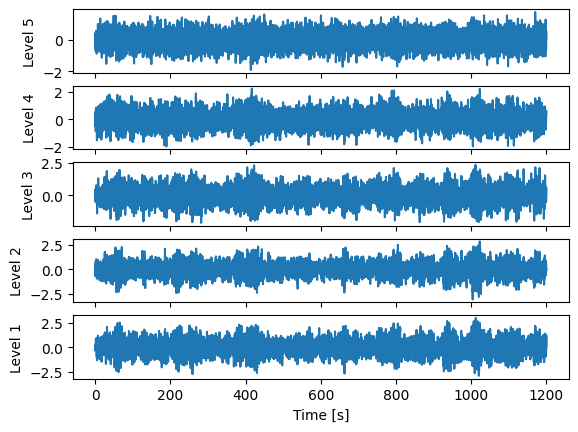

In [12]:
fig, ax = plt.subplots(nrows=levels, ncols=1, num=1, sharex =True)

for level, axi in enumerate(ax[::-1]):    
    axi.plot(t, data[:,level])
    axi.set_ylabel(f'Level {level+1}')

__ = ax[-1].set_xlabel('Time [s]')
display(fig)

## Welch CPSD estimation and FDD
Here, a CPSD matrix is estimated using Welch's method (using KOMA function xwelch, based on scipy's csd function). This is thereafter used to estimate U and D (SVD) one frequency component at the time (=FDD). 

Thereafter, the resulting matrices are input to the created `koma.plot.FDDPlotter` object, which can be used to interactively choose the relevant frequency lines. The resulting `koma.plot.FDDPlotter.phi` yields the updated results. As the magic `%matplotlib` function is used on top, the plot shows in a separate window to enable interaction. The display command in the next cell shows a copy of the latest state of the figure inline.

In [9]:
f, cpsd = xwelch(data, fs=fs, nfft=2048, nperseg=1024)
U, D = koma.oma.freq_svd(cpsd)
fdd_plotter = koma.plot.FDDPlotter(D, U=U, f=f, lines=[0, 1], num=1)
fig = fdd_plotter.get_fig()

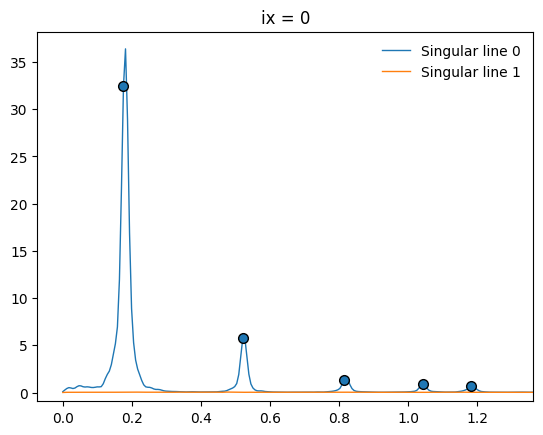

In [10]:
display(fig)
phi_fdd = fdd_plotter.phi

## Visualization: mode shapes

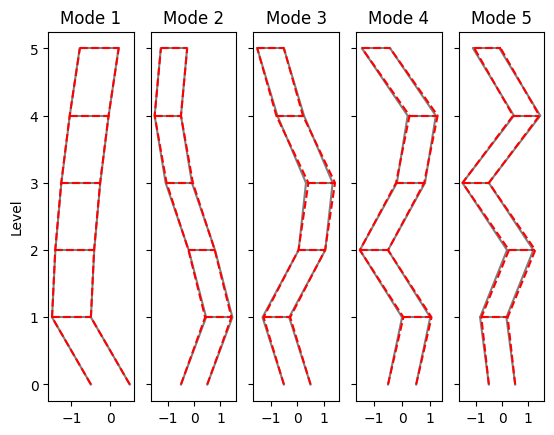

In [11]:
fig, ax = plot_all_modes(levels, phi_ref, phi_fdd)
display(fig)